In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="ticks", color_codes=True)
%matplotlib inline

In [482]:
df = pd.read_csv('data/60-120grid30-85agents0-30obstacle_ratio-labelled.csv')

In [483]:
features_cols = ['GridSize', 'NumOfAgents', 'NumOfObstacles', 'ObstacleDensity',
            'AvgDistanceToGoal', 'MaxDistanceToGoal', 'MinDistanceToGoal', 'AvgStartDistances', 'AvgGoalDistances',
            'PointsAtSPRatio', 'Sparsity']
# features_cols = [ 'NumOfAgents', 'ObstacleDensity', 'PointsAtSPRatio', 'NumOfObstacles']


## Replace every row with runtime greater then 300000 (5 minutes) to be 300000 - removing computation errors ##

In [484]:
runtime_cols = list(df.filter(like="Runtime"))
for runtime_col in runtime_cols:
    df[runtime_col] = df[runtime_col].where(df[runtime_col] < 300000, 300000)


In [725]:
runtime_cols = list(df.filter(like="Runtime"))

runtime_cols

['A*+OD+ID Runtime',
 'MA-CBS-Global-10/(A*+OD/SIC) choosing the first conflict in CBS nodes Runtime',
 'MA-CBS-Local-10/(single:A*/SIC multi:A*+OD/SIC) choosing the first conflict in CBS nodes Runtime',
 'Basic-CBS/(A*+OD/SIC) choosing the first conflict in CBS nodes Runtime',
 'MA-CBS-Global-10/(EPEA*/SIC) choosing the first conflict in CBS nodes Runtime',
 'MA-CBS-Local-10/(single:A*/SIC multi:EPEA*/SIC) choosing the first conflict in CBS nodes Runtime',
 'Basic-CBS/(A*/SIC) choosing cardinal conflicts using lookahead Runtime',
 'Basic-CBS/(A*/SIC)+ID Runtime',
 'Y Runtime',
 'P Runtime']

In [486]:
df['Y'].value_counts()

A*+OD+ID Runtime                                                                                    388
MA-CBS-Global-10/(EPEA*/SIC) choosing the first conflict in CBS nodes Runtime                       286
MA-CBS-Local-10/(single:A*/SIC multi:EPEA*/SIC) choosing the first conflict in CBS nodes Runtime    242
Basic-CBS/(A*/SIC)+ID Runtime                                                                       221
MA-CBS-Local-10/(single:A*/SIC multi:A*+OD/SIC) choosing the first conflict in CBS nodes Runtime    129
Basic-CBS/(A*/SIC) choosing cardinal conflicts using lookahead Runtime                               33
Basic-CBS/(A*+OD/SIC) choosing the first conflict in CBS nodes Runtime                               23
MA-CBS-Global-10/(A*+OD/SIC) choosing the first conflict in CBS nodes Runtime                        18
Name: Y, dtype: int64

In [282]:
    # Replacing Y LABEL WITH ONE HOT ECONDING
# for col in df.dtypes[df.dtypes == 'object'].index:
#     for_dummy = df.pop(col)
#     df = pd.concat([df, pd.get_dummies(for_dummy, prefix=col)], axis=1)

In [274]:
# ost_df = df[df['GridName'] == 'ost003d']
# den_df = df[df['GridName'] == 'den502d']
# brc_df = df[df['GridName'] == 'brc202d']

In [275]:
# df = ost_df

In [474]:
from sklearn.metrics import confusion_matrix 
from sklearn.model_selection import train_test_split  
labels= ['A*+OD+ID Runtime',
 'MA-CBS-Global-10/(A*+OD/SIC) choosing the first conflict in CBS nodes Runtime',
 'MA-CBS-Local-10/(single:A*/SIC multi:A*+OD/SIC) choosing the first conflict in CBS nodes Runtime',
 'Basic-CBS/(A*+OD/SIC) choosing the first conflict in CBS nodes Runtime',
 'MA-CBS-Global-10/(EPEA*/SIC) choosing the first conflict in CBS nodes Runtime',
 'MA-CBS-Local-10/(single:A*/SIC multi:EPEA*/SIC) choosing the first conflict in CBS nodes Runtime',
 'Basic-CBS/(A*/SIC) choosing cardinal conflicts using lookahead Runtime',
 'Basic-CBS/(A*/SIC)+ID Runtime']
# 'ICTS 2RE Runtime']
# dividing X, y into train and test data 
X_train, X_test, y_train, y_test = train_test_split(df, df['Y'], test_size=0.25) 

## XGBoost training

In [472]:
        # # THIS USED FOR REPLACING MAPF ALGORITHM NAMES WITH 0-8 VALUES
        # df = df.replace({'MA-CBS-Global-10/(EPEA*/SIC) choosing the first conflict in CBS nodes Runtime': 0,
        #             'Basic-CBS/(A*/SIC) choosing cardinal conflicts using lookahead Runtime': 1,
        #              'MA-CBS-Local-10/(single:A*/SIC multi:EPEA*/SIC) choosing the first conflict in CBS nodes Runtime':2,
        #            'MA-CBS-Global-10/(A*+OD/SIC) choosing the first conflict in CBS nodes Runtime':3,
        #            'MA-CBS-Local-10/(single:A*/SIC multi:A*+OD/SIC) choosing the first conflict in CBS nodes Runtime':4,
        #            'Basic-CBS/(A*+OD/SIC) choosing the first conflict in CBS nodes Runtime':5,
        #            'A*+OD+ID Runtime':6,
        #            'Basic-CBS/(A*/SIC)+ID Runtime':7,
        #            'ICTS 2RE Runtime':8})


In [683]:
import xgboost as xgb

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df, df['Y'], test_size=0.25)

xg_cls = xgb.XGBClassifier(n_estimators=100, max_depth=3, learning_rate=0.1, subsample=0.8, gamma=1, colsample_bytree=1)

xg_cls.fit(X_train[features_cols],y_train)

preds = xg_cls.predict(X_test[features_cols])

In [684]:
from sklearn.metrics import accuracy_score

accuracy_score(y_test, preds)

0.4208955223880597

In [765]:
runtime_per_algo = {}
for runtime in runtime_cols:
    substr_index = runtime.rfind(')')
    if(substr_index!=-1):
        key = runtime[:substr_index+1]
    else:
        key = runtime
    runtime_per_algo[key] = X_test[runtime].sum() 

In [766]:
runtime_per_algo

{'A*+OD+ID Runtime': 26753822.940100104,
 'MA-CBS-Global-10/(A*+OD/SIC)': 50837959.64040023,
 'MA-CBS-Local-10/(single:A*/SIC multi:A*+OD/SIC)': 52846346.13399975,
 'Basic-CBS/(A*+OD/SIC)': 54818681.388899975,
 'MA-CBS-Global-10/(EPEA*/SIC)': 52283413.513500065,
 'MA-CBS-Local-10/(single:A*/SIC multi:EPEA*/SIC)': 53308232.33289956,
 'Basic-CBS/(A*/SIC)': 36533380.8718999,
 'Y Runtime': 20595599.67699966,
 'P Runtime': 22689896.633899666}

<BarContainer object of 9 artists>

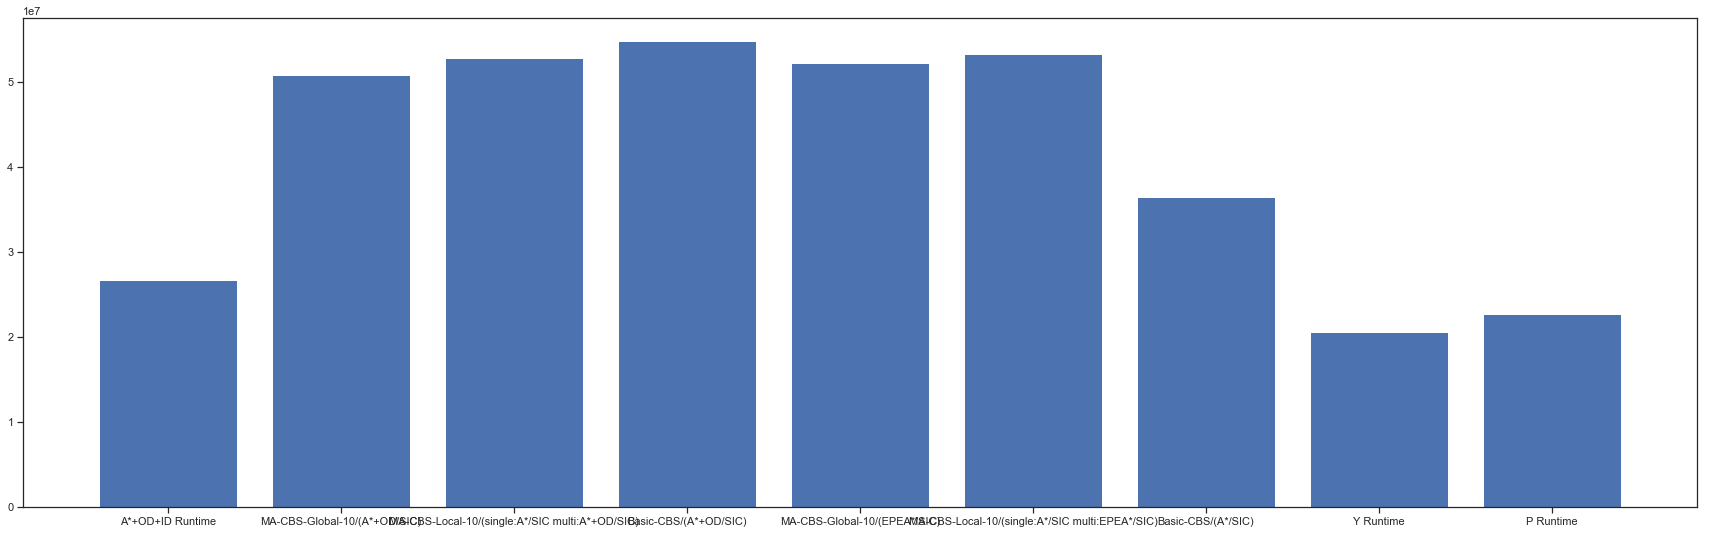

In [767]:
plt.bar(*zip(*runtime_per_algo.items()))

In [758]:
pd.DataFrame.from_dict(runtime_per_algo)

ValueError: If using all scalar values, you must pass an index

In [756]:
with sns.axes_style('white'):
    g = sns.factorplot("year", data=runtime_per_algo, aspect=2,
                       kind="count", color='steelblue')


ValueError: Either `x` or `y` must be None for count plots

## GBM training

In [475]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1005, 284), (1005,), (335, 284), (335,))

In [450]:
from sklearn.ensemble import GradientBoostingClassifier
model = GradientBoostingClassifier(max_features=6, max_depth=4)
model.fit(X_train[features_cols], y_train)
    
# GradientBoostingClassifier(criterion=’friedman_mse’, init=None,
#  learning_rate=0.1, loss=’deviance’, max_depth=3,
#  max_features=None, max_leaf_nodes=None,
#  min_impurity_split=1e-07, min_samples_leaf=1,
#  min_samples_split=2, min_weight_fraction_leaf=0.0,
#  n_estimators=100, presort=’auto’, random_state=None,
#  subsample=1.0, verbose=0, warm_start=False)
y_pred = model.predict(X_test[features_cols])

In [451]:
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix

cm = confusion_matrix(y_test, y_pred)
accuracy_score(y_test, y_pred)

0.3611940298507463

In [685]:
def runtime_to_success(col):
    splitted = col.split()
    splitted[-1] = "Success"
    return " ".join(splitted)

runtime_to_success("Y Runtime")

'Y Success'

## Adding 'P Success' column to indicate if the predicted algorithm finished before 5 minutes ##

In [694]:
X_test['P'] = X_test.apply(lambda x: model.predict(x[features_cols].to_frame().transpose())[0], axis=1)
df['P'] = df.apply(lambda x: model.predict(x[features_cols].to_frame().transpose())[0], axis=1)

c:\users\omri\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [688]:
X_test['P Success'] = X_test.apply(lambda x:x[runtime_to_success(x['P'])], axis=1)
df['P Success'] = df.apply(lambda x:x[runtime_to_success(x['P'])], axis=1)

c:\users\omri\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [689]:
X_test['P Runtime'] = X_test.apply(lambda x:x[x['P']], axis=1)
df['P Runtime'] = df.apply(lambda x:x[x['P']], axis=1)


c:\users\omri\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


## Let's visualize the success rate of our predicted alogrithm according to the oracle  ##
### NOTE: THIS GRAPH USED WITH TRAIN DATA ALSO ###

A*+OD+ID Success
MA-CBS-Global-10/(A*+OD/SIC) choosing the first conflict in CBS nodes Success
MA-CBS-Local-10/(single:A*/SIC multi:A*+OD/SIC) choosing the first conflict in CBS nodes Success
Basic-CBS/(A*+OD/SIC) choosing the first conflict in CBS nodes Success
MA-CBS-Global-10/(EPEA*/SIC) choosing the first conflict in CBS nodes Success
MA-CBS-Local-10/(single:A*/SIC multi:EPEA*/SIC) choosing the first conflict in CBS nodes Success
Basic-CBS/(A*/SIC) choosing cardinal conflicts using lookahead Success
Basic-CBS/(A*/SIC)+ID Success
Y Success
P Success


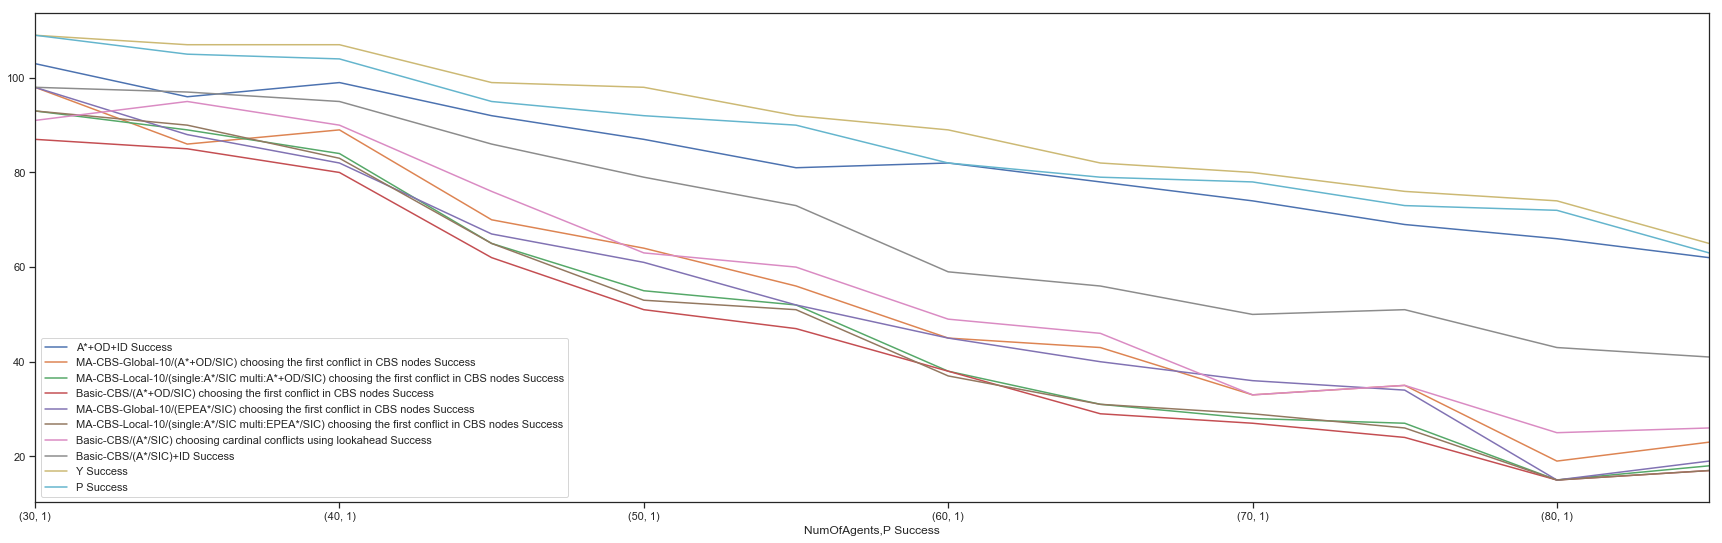

In [711]:
ax = plt.gca()
plt.rcParams["figure.figsize"] = (30,9)

for runtime_col in runtime_cols:
    print(runtime_to_success(runtime_col))
    s = df.groupby("NumOfAgents")[runtime_to_success(runtime_col)].value_counts()
    s.to_frame()[s.index.to_frame()[runtime_to_success(runtime_col)] == 1][runtime_to_success(runtime_col)].plot(ax=ax)
    
ax.legend()
    

## Let's visualize the success rate of our predicted alogrithm according to the oracle  ##

A*+OD+ID Success
MA-CBS-Global-10/(A*+OD/SIC) choosing the first conflict in CBS nodes Success
MA-CBS-Local-10/(single:A*/SIC multi:A*+OD/SIC) choosing the first conflict in CBS nodes Success
Basic-CBS/(A*+OD/SIC) choosing the first conflict in CBS nodes Success
MA-CBS-Global-10/(EPEA*/SIC) choosing the first conflict in CBS nodes Success
MA-CBS-Local-10/(single:A*/SIC multi:EPEA*/SIC) choosing the first conflict in CBS nodes Success
Basic-CBS/(A*/SIC) choosing cardinal conflicts using lookahead Success
Basic-CBS/(A*/SIC)+ID Success
Y Success
P Success


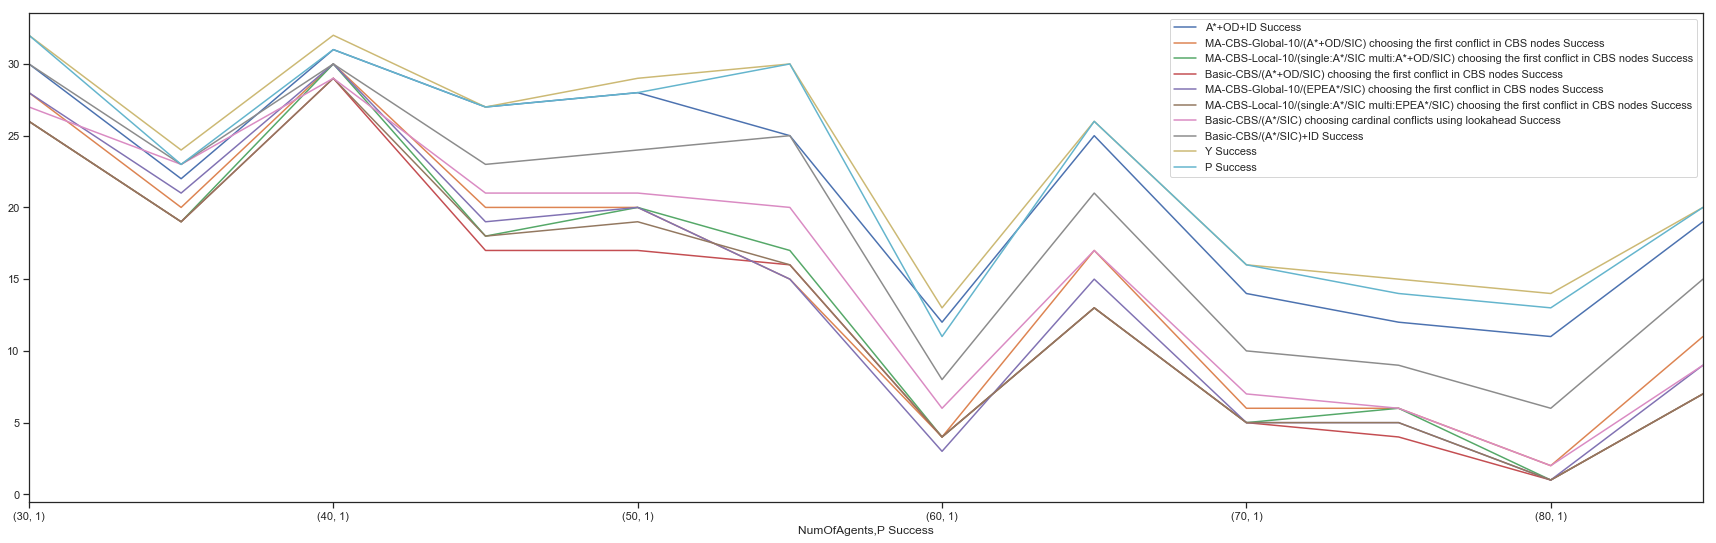

In [712]:
ax = plt.gca()
plt.rcParams["figure.figsize"] = (30,9)

for runtime_col in runtime_cols:
    print(runtime_to_success(runtime_col))
    s = X_test.groupby("NumOfAgents")[runtime_to_success(runtime_col)].value_counts()
    s.to_frame()[s.index.to_frame()[runtime_to_success(runtime_col)] == 1][runtime_to_success(runtime_col)].plot(ax=ax)
    
ax.legend()


In [47]:
import seaborn as sns; sns.set(style="ticks", color_codes=True)

A*+OD+ID Success
MA-CBS-Global-10/(A*+OD/SIC) choosing the first conflict in CBS nodes Success


C:\Users\omri\AppData\Roaming\Python\Python36\site-packages\matplotlib\tight_layout.py:176: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  warnings.warn('Tight layout not applied. The left and right margins '


MA-CBS-Local-10/(single:A*/SIC multi:A*+OD/SIC) choosing the first conflict in CBS nodes Success
Basic-CBS/(A*+OD/SIC) choosing the first conflict in CBS nodes Success
MA-CBS-Global-10/(EPEA*/SIC) choosing the first conflict in CBS nodes Success
MA-CBS-Local-10/(single:A*/SIC multi:EPEA*/SIC) choosing the first conflict in CBS nodes Success
Basic-CBS/(A*/SIC) choosing cardinal conflicts using lookahead Success
Basic-CBS/(A*/SIC)+ID Success
Y Success
P Success


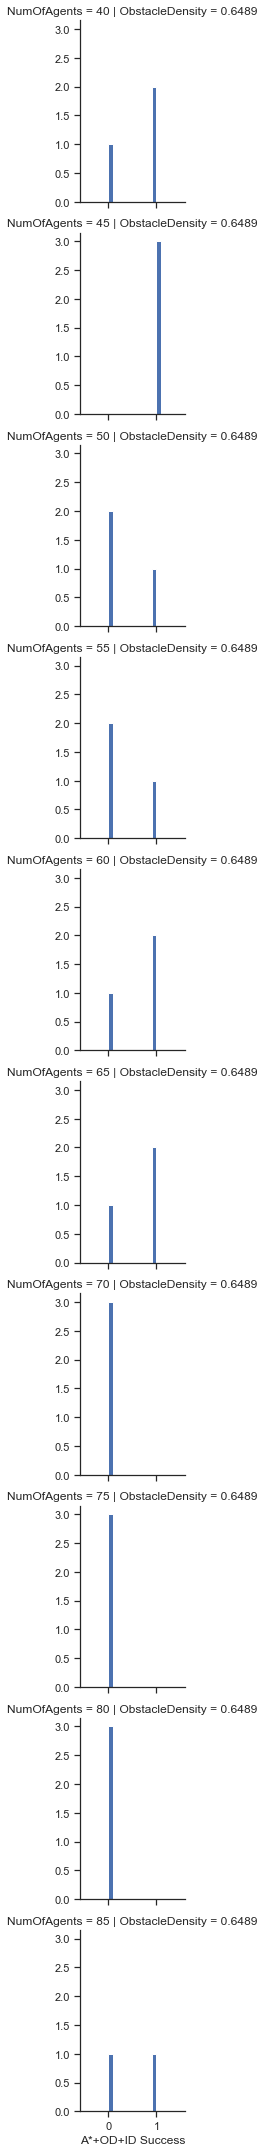

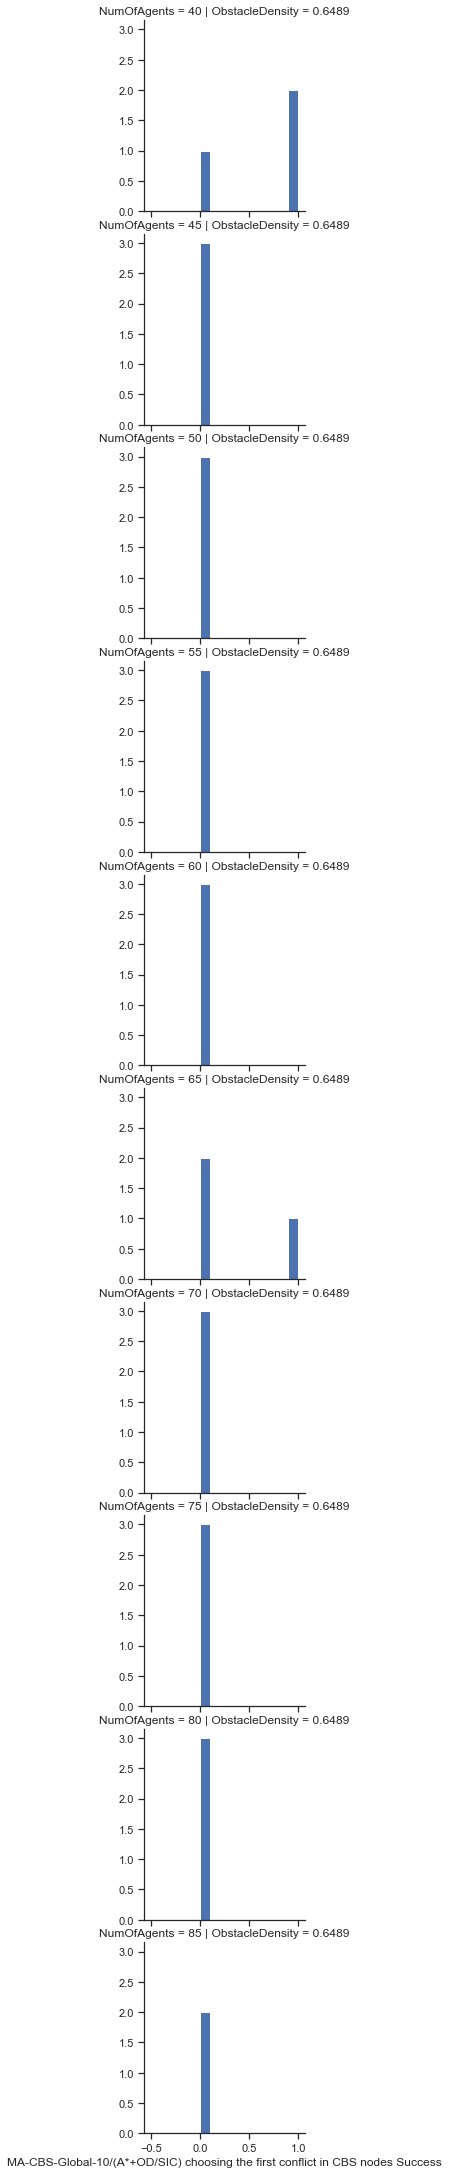

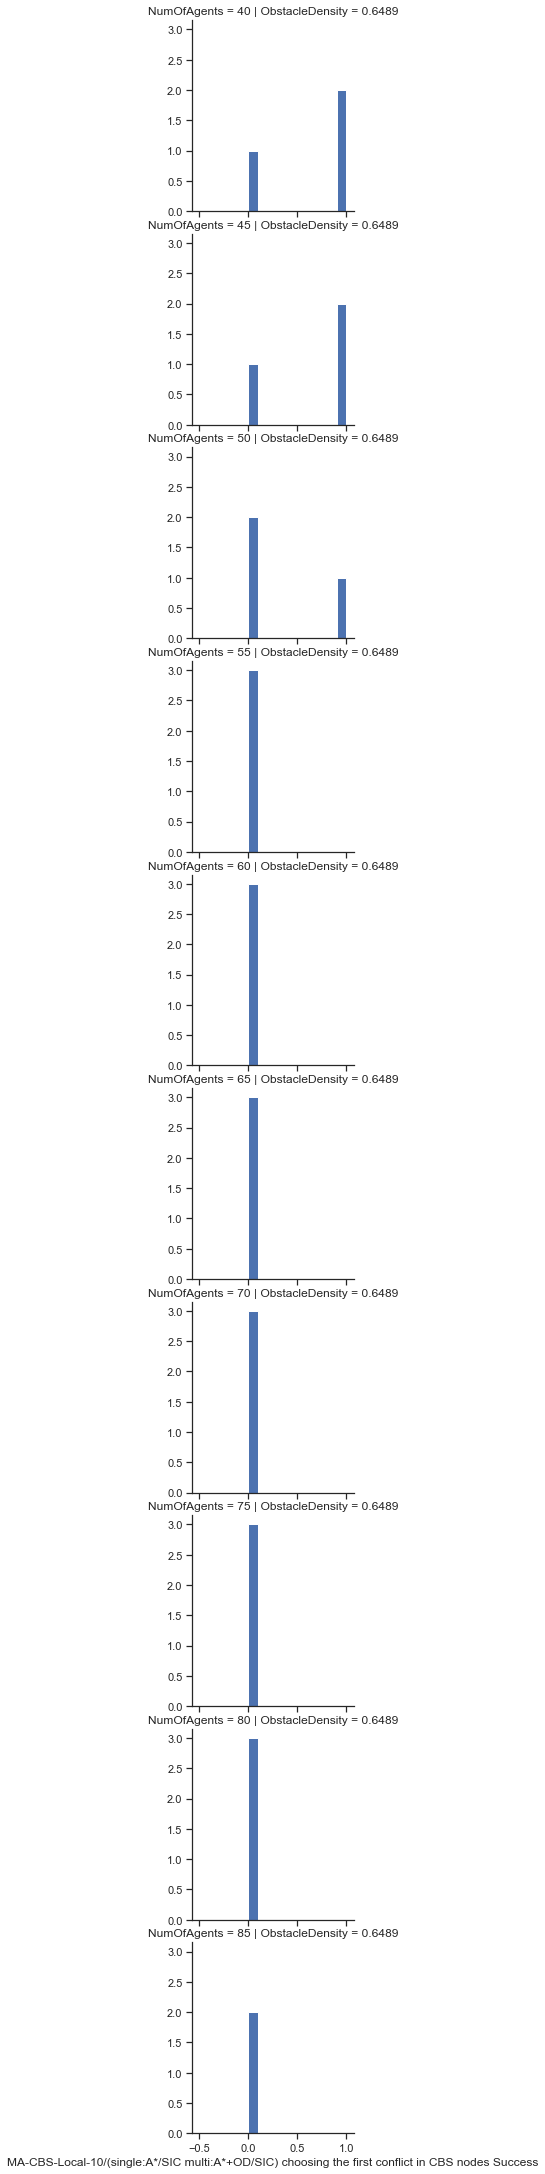

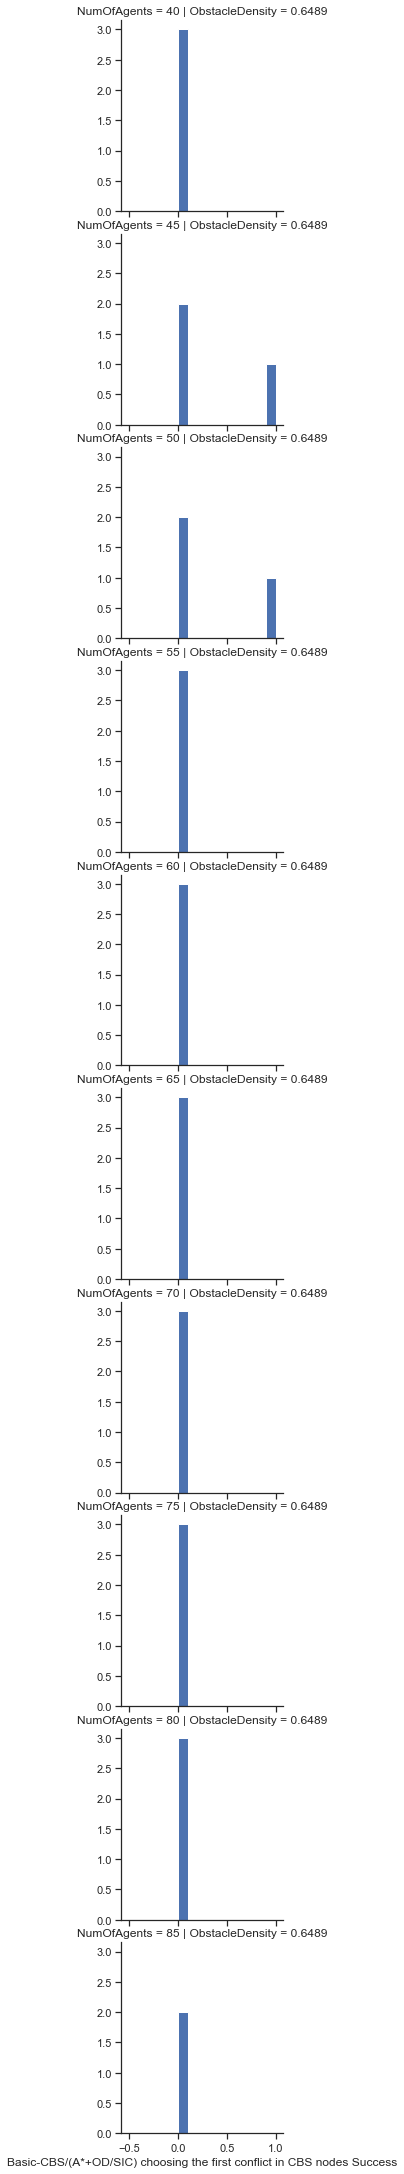

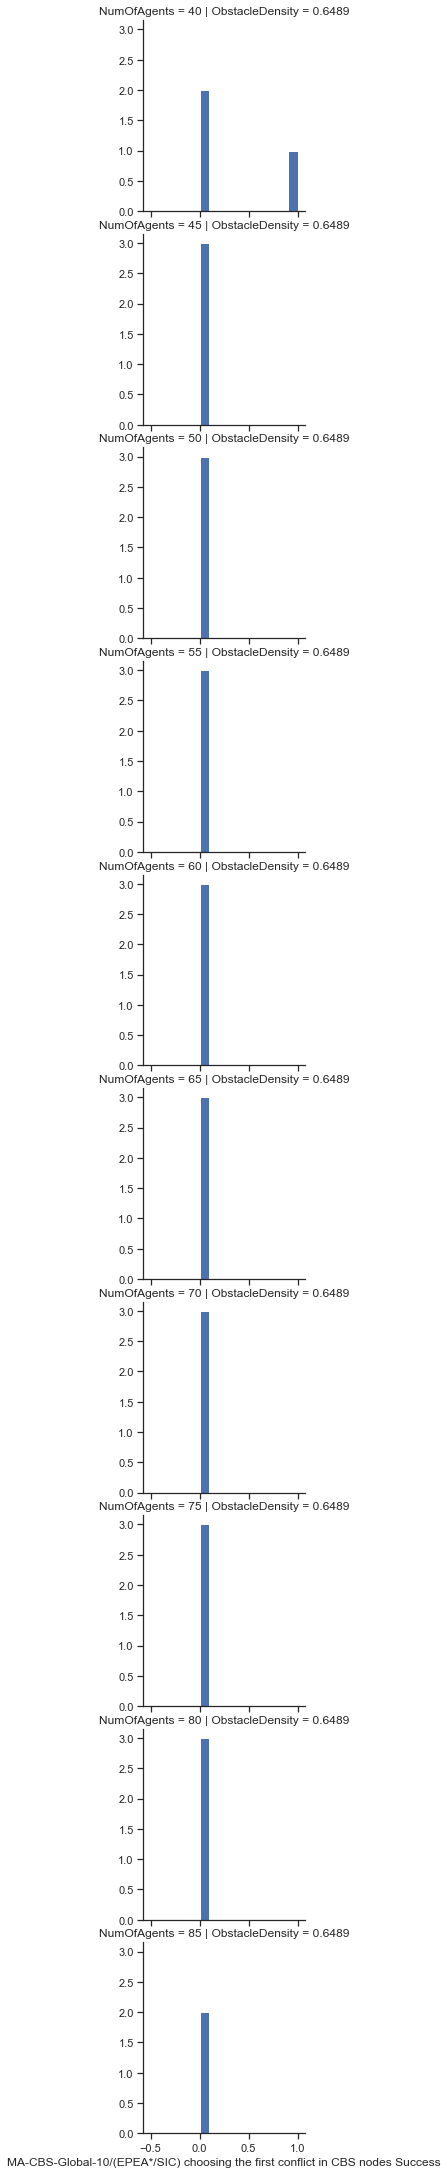

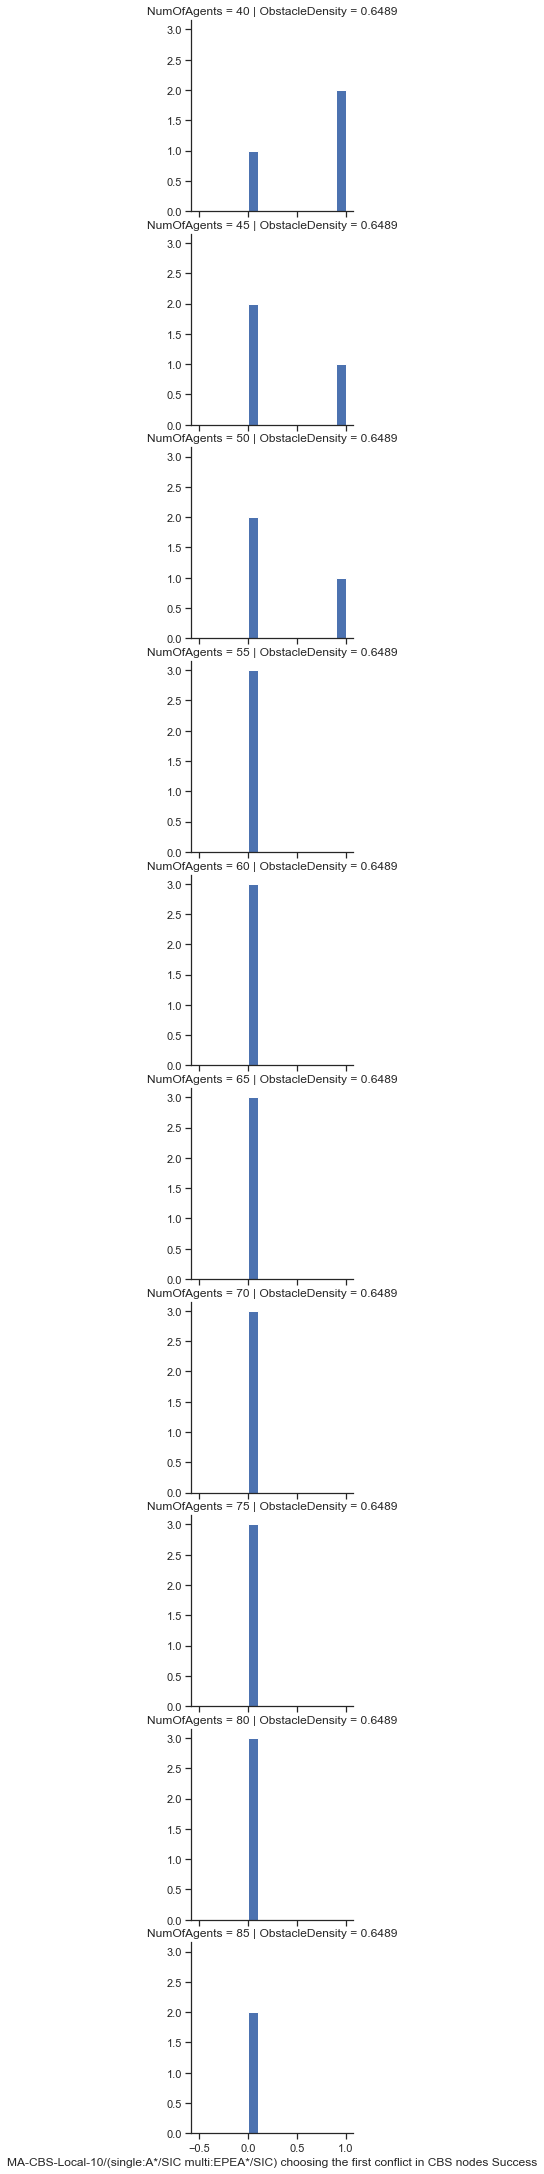

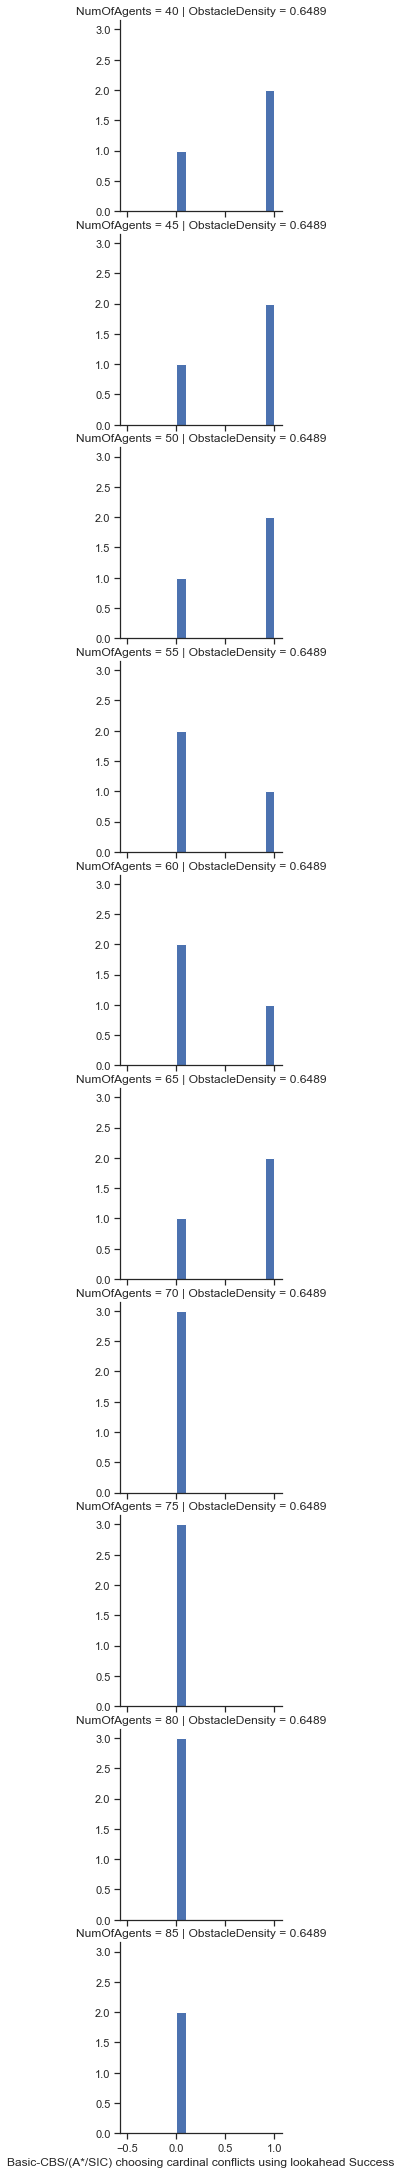

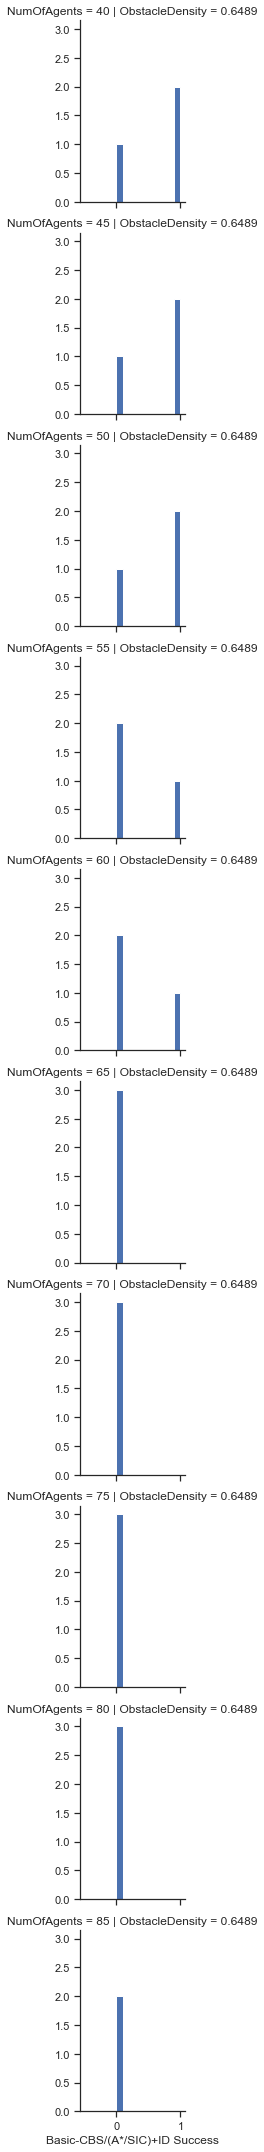

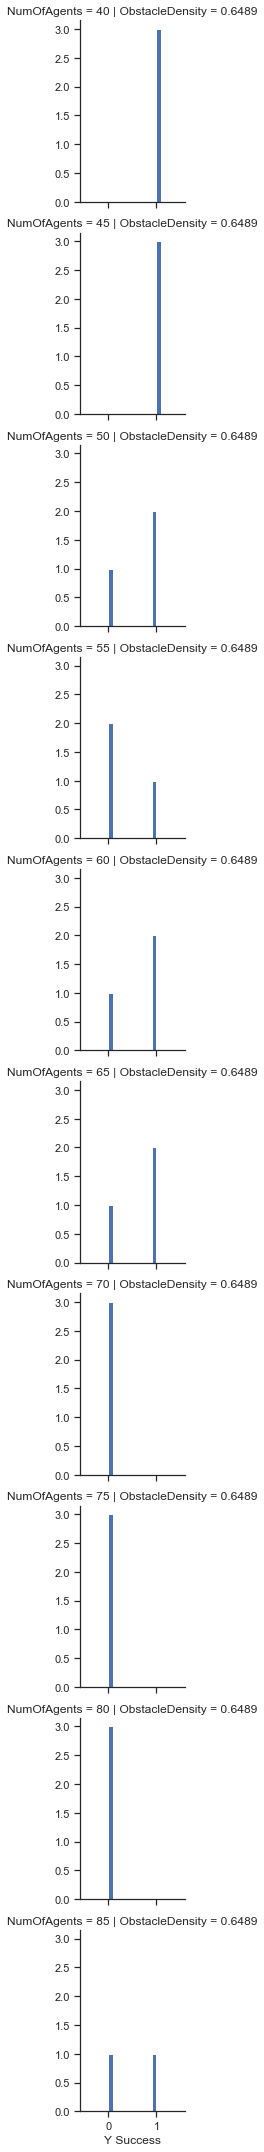

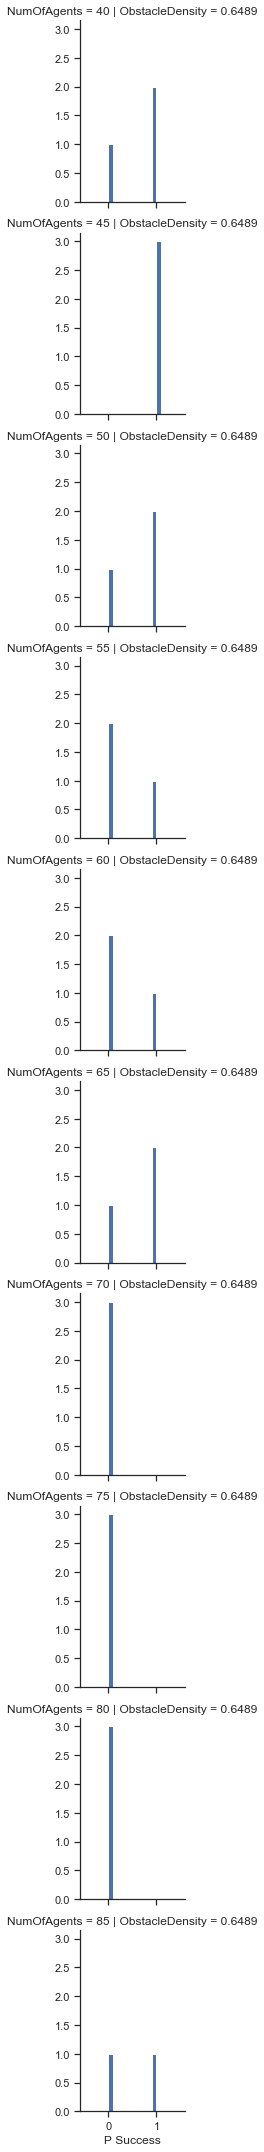

In [59]:
for runtime_col in runtime_cols:
    print(runtime_to_success(runtime_col))
#     s = X_test.groupby("GridRows")[runtime_to_success(runtime_col)].value_counts()
#     s.to_frame()[s.index.to_frame()[runtime_to_success(runtime_col)] == 1][runtime_to_success(runtime_col)].plot(ax=ax)
    g = sns.FacetGrid(df, col="ObstacleDensity", row="NumOfAgents")
    g = g.map(plt.hist, runtime_to_success(runtime_col))

In [244]:
runtime_cols

['A*+OD+ID Runtime',
 'MA-CBS-Global-10/(A*+OD/SIC) choosing the first conflict in CBS nodes Runtime',
 'MA-CBS-Local-10/(single:A*/SIC multi:A*+OD/SIC) choosing the first conflict in CBS nodes Runtime',
 'Basic-CBS/(A*+OD/SIC) choosing the first conflict in CBS nodes Runtime',
 'MA-CBS-Global-10/(EPEA*/SIC) choosing the first conflict in CBS nodes Runtime',
 'MA-CBS-Local-10/(single:A*/SIC multi:EPEA*/SIC) choosing the first conflict in CBS nodes Runtime',
 'Basic-CBS/(A*/SIC) choosing cardinal conflicts using lookahead Runtime',
 'Basic-CBS/(A*/SIC)+ID Runtime',
 'Y Runtime',
 'P Runtime']

In [149]:
df2 = pd.read_csv('data/60-120grid30-85agents0-30obstacle_ratio-labelled.csv')
df2['Y'].value_counts()

A*+OD+ID Runtime                                                                                    388
MA-CBS-Global-10/(EPEA*/SIC) choosing the first conflict in CBS nodes Runtime                       286
MA-CBS-Local-10/(single:A*/SIC multi:EPEA*/SIC) choosing the first conflict in CBS nodes Runtime    242
Basic-CBS/(A*/SIC)+ID Runtime                                                                       221
MA-CBS-Local-10/(single:A*/SIC multi:A*+OD/SIC) choosing the first conflict in CBS nodes Runtime    129
Basic-CBS/(A*/SIC) choosing cardinal conflicts using lookahead Runtime                               33
Basic-CBS/(A*+OD/SIC) choosing the first conflict in CBS nodes Runtime                               23
MA-CBS-Global-10/(A*+OD/SIC) choosing the first conflict in CBS nodes Runtime                        18
Name: Y, dtype: int64

In [150]:
y_pred2 = model.predict(df2[features_cols])

accuracy_score(df2['Y'], y_pred2)

0.841044776119403

[ 30.83843822  28.38179329  50.20634331  56.17932963  31.55746009
  95.76347701  83.26546274  69.95871324  93.05966058  92.18440909
 100.        ]
['GridColumns' 'GridRows' 'ObstacleDensity' 'NumOfAgents' 'NumOfObstacles'
 'MinDistanceToGoal' 'MaxDistanceToGoal' 'AvgGoalDistances'
 'AvgStartDistances' 'AvgDistanceToGoal' 'PointsAtSPRatio']
[ 1  0  4  2  3  7  6  9  8  5 10]


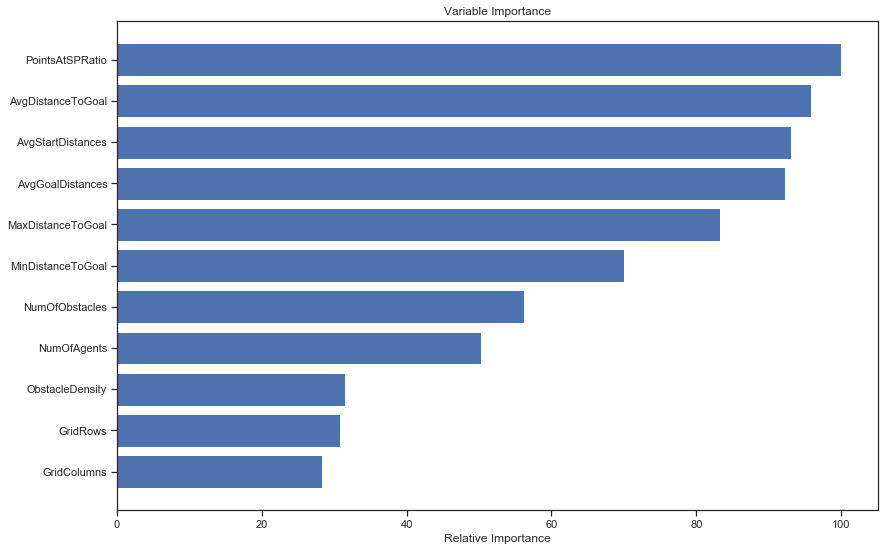

In [285]:
import numpy as np

features_cols = ['GridRows', 'GridColumns', 'NumOfAgents', 'NumOfObstacles', 'ObstacleDensity',
            'AvgDistanceToGoal', 'MaxDistanceToGoal', 'MinDistanceToGoal', 'AvgStartDistances', 'AvgGoalDistances',
            'PointsAtSPRatio']

feature_importance = model.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
print(feature_importance)
sorted_idx = np.argsort(feature_importance)
print(np.array(features_cols)[sorted_idx])
print(sorted_idx)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, np.array(features_cols)[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

Text(0, 0.5, '')

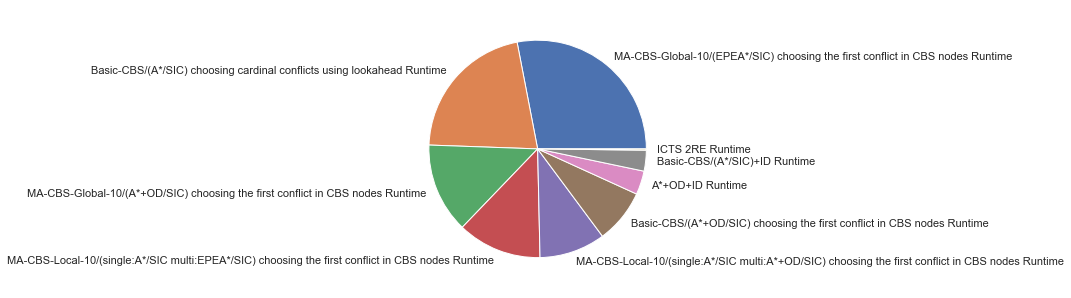

In [287]:
ax = plt.gca()
plt.rcParams["figure.figsize"] = (8,5)

pie_plt = df['Y'].value_counts().plot(kind='pie', legend=False, ax=ax)
pie_plt.set_ylabel('') #Removing column label from the plot

In [56]:
den_df['Y'].value_counts()

A*+OD+ID Runtime                                                                                    9
Basic-CBS/(A*/SIC)+ID Runtime                                                                       7
MA-CBS-Global-10/(EPEA*/SIC) choosing the first conflict in CBS nodes Runtime                       5
MA-CBS-Local-10/(single:A*/SIC multi:A*+OD/SIC) choosing the first conflict in CBS nodes Runtime    3
Basic-CBS/(A*/SIC) choosing cardinal conflicts using lookahead Runtime                              3
MA-CBS-Local-10/(single:A*/SIC multi:EPEA*/SIC) choosing the first conflict in CBS nodes Runtime    2
Name: Y, dtype: int64

In [40]:
pd.Series(y_pred).value_counts().plot(kind='pie')

NameError: name 'y_pred' is not defined

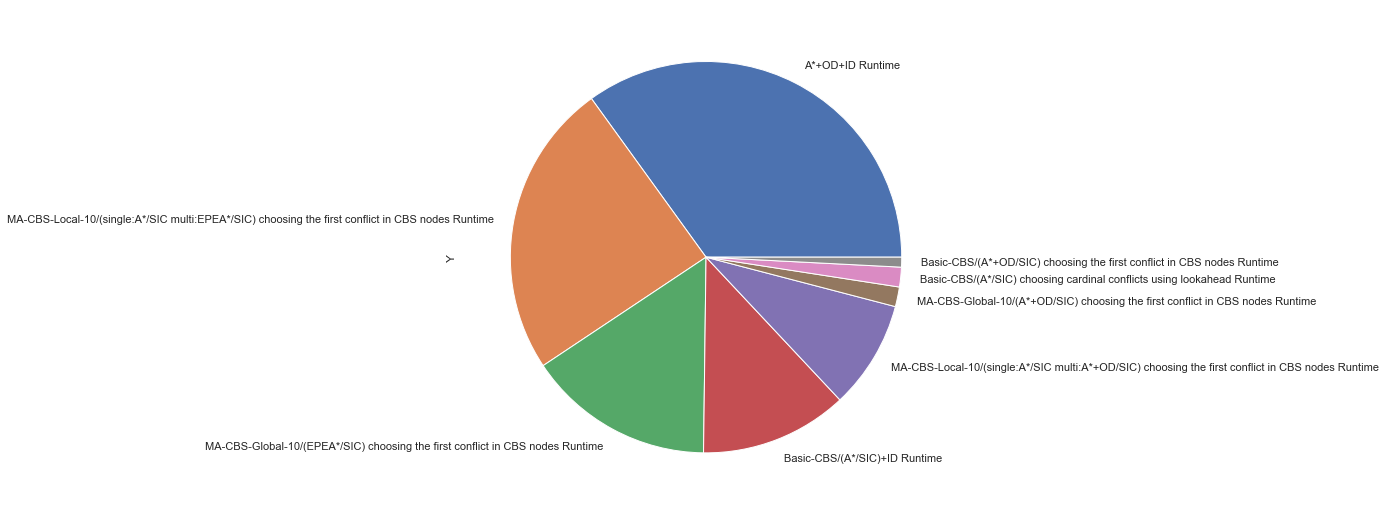

In [342]:
pd.Series(y_test).value_counts().plot(kind='pie')

In [122]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

                                                                                                  precision    recall  f1-score   support

                                                                                A*+OD+ID Runtime       0.64      0.41      0.50        22
                          Basic-CBS/(A*+OD/SIC) choosing the first conflict in CBS nodes Runtime       0.09      0.08      0.09        62
                          Basic-CBS/(A*/SIC) choosing cardinal conflicts using lookahead Runtime       0.27      0.24      0.25       151
                                                                   Basic-CBS/(A*/SIC)+ID Runtime       0.57      0.40      0.47        20
                                                                                ICTS 2RE Runtime       0.00      0.00      0.00         1
                   MA-CBS-Global-10/(A*+OD/SIC) choosing the first conflict in CBS nodes Runtime       0.12      0.10      0.11        86
                   MA-CBS-Global-

c:\users\omri\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


c:\users\omri\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


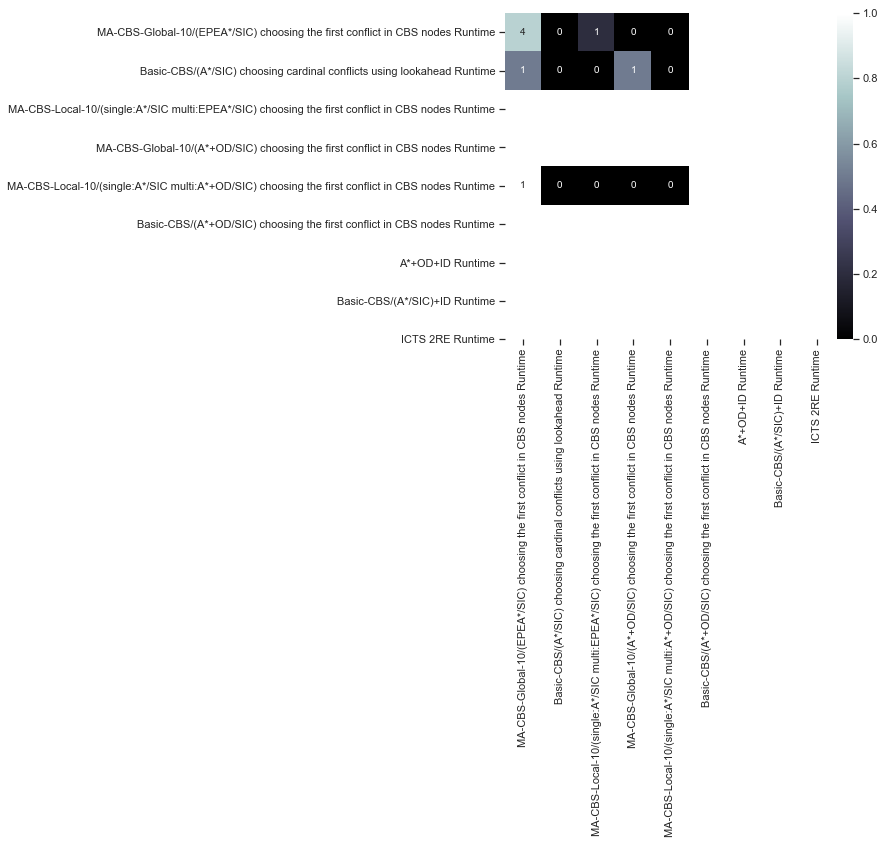

In [40]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes, normalized=True, cmap='bone'):
    plt.figure(figsize=[7, 6])
    norm_cm = cm
    if normalized:
        norm_cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        sns.heatmap(norm_cm, annot=cm, fmt='g', xticklabels=classes, yticklabels=classes, cmap=cmap)
        plt.savefig('confusion-matrix.png')

plot_confusion_matrix(cm, ['MA-CBS-Global-10/(EPEA*/SIC) choosing the first conflict in CBS nodes Runtime',
            'Basic-CBS/(A*/SIC) choosing cardinal conflicts using lookahead Runtime',
             'MA-CBS-Local-10/(single:A*/SIC multi:EPEA*/SIC) choosing the first conflict in CBS nodes Runtime',
           'MA-CBS-Global-10/(A*+OD/SIC) choosing the first conflict in CBS nodes Runtime',
           'MA-CBS-Local-10/(single:A*/SIC multi:A*+OD/SIC) choosing the first conflict in CBS nodes Runtime',
           'Basic-CBS/(A*+OD/SIC) choosing the first conflict in CBS nodes Runtime',
           'A*+OD+ID Runtime',
           'Basic-CBS/(A*/SIC)+ID Runtime',
           'ICTS 2RE Runtime'])

In [81]:
max_depths = np.linspace(1, 32, 32, endpoint=True)
train_results = []
test_results = []
for max_depth in max_depths:
    model = GradientBoostingClassifier(max_depth=max_depth)
    model.fit(X_train, y_train)
    train_pred = model.predict(X_train)
    acc_train = accuracy_score(y_train, train_pred)
    train_results.append(acc_train)
    y_pred = model.predict(X_test)
    acc_test = accuracy_score(y_test, y_pred)
    test_results.append(acc_test)
    
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(max_depths, train_results, 'b', label='Train accuracy')
line2, = plt.plot(max_depths, test_results, 'r', label='Test accuracy')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('accuracy')
plt.xlabel('Tree depth')
plt.title('GBM Accuracy according to maximum depth of each tree ')
plt.show()

ValueError: could not convert string to float: 'Unknown'

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]


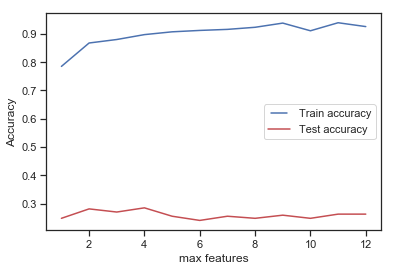

In [182]:
max_features = list(range(1, len(features_cols)+1))
print(max_features)
train_results = []
test_results = []
for max_feature in max_features:
    model = GradientBoostingClassifier(max_features=max_feature)
    model.fit(X_train, y_train)
    train_pred = model.predict(X_train)
    acc_train = accuracy_score(y_train, train_pred)
    train_results.append(acc_train)
    y_pred = model.predict(X_test)
    acc_test = accuracy_score(y_test, y_pred)
    test_results.append(acc_test)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(max_features, train_results, 'b', label='Train accuracy')
line2, = plt.plot(max_features, test_results, 'r', label='Test accuracy')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('Accuracy')
plt.xlabel('max features')
plt.show()

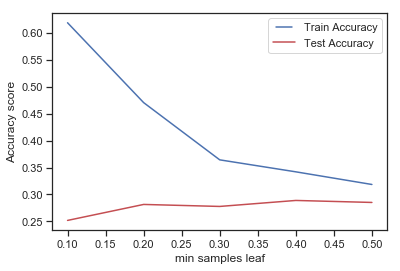

In [191]:
min_samples_leafs = np.linspace(0.1, 0.5, 5, endpoint=True)
train_results = []
test_results = []
for min_samples_leaf in min_samples_leafs:
    model = GradientBoostingClassifier(min_samples_leaf=min_samples_leaf)
    model.fit(X_train, y_train)
    train_pred = model.predict(X_train)
    acc_train = accuracy_score(y_train, train_pred)
    train_results.append(acc_train)
    y_pred = model.predict(X_test)
    acc_test = accuracy_score(y_test, y_pred)
    test_results.append(acc_test)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(min_samples_leafs, train_results, 'b', label='Train Accuracy')
line2, = plt.plot(min_samples_leafs, test_results, 'r', label='Test Accuracy')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('Accuracy score')
plt.xlabel('min samples leaf')
plt.show()

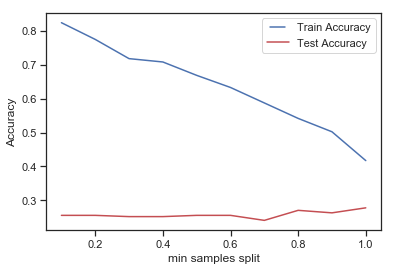

In [189]:
min_samples_splits = np.linspace(0.1, 1.0, 10, endpoint=True)
train_results = []
test_results = []
for min_samples_split in min_samples_splits:
    model = GradientBoostingClassifier(min_samples_split=min_samples_split)
    model.fit(X_train, y_train)
    train_pred = model.predict(X_train)
    acc_train = accuracy_score(y_train, train_pred)
    train_results.append(acc_train)
    y_pred = model.predict(X_test)
    acc_test = accuracy_score(y_test, y_pred)
    test_results.append(acc_test)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(min_samples_splits, train_results, 'b', label='Train Accuracy')
line2, = plt.plot(min_samples_splits, test_results, 'r', label='Test Accuracy')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('Accuracy')
plt.xlabel('min samples split')
plt.show()

In [63]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((810, 12), (810,), (270, 12), (270,))

In [39]:
import xgboost as xgb

dtrain = xgb.DMatrix(data=X_train, label=y_train)
dtest = xgb.DMatrix(data=X_test)

In [40]:
params = {
    'max_depth': 6,
    'objective': 'multi:softmax',  # error evaluation for multiclass training
    'num_class': 9,
    'n_gpus': 0
}

In [47]:
bst = xgb.train(params, dtrain)

In [45]:
pred = bst.predict(dtest)

In [46]:
from sklearn.metrics import classification_report

print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.25      0.59      0.36        66
           1       0.25      0.19      0.22        67
           2       0.23      0.07      0.11        44
           3       0.27      0.18      0.21        34
           4       0.14      0.12      0.13        24
           5       0.00      0.00      0.00        18
           6       0.00      0.00      0.00         9
           7       0.00      0.00      0.00         6
           8       0.00      0.00      0.00         2

   micro avg       0.24      0.24      0.24       270
   macro avg       0.13      0.13      0.11       270
weighted avg       0.21      0.24      0.20       270



c:\users\omri\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [48]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, pred)
cm

array([[39, 17,  1,  3,  5,  1,  0,  0,  0],
       [40, 13,  5,  4,  4,  0,  0,  1,  0],
       [27,  8,  3,  1,  3,  1,  1,  0,  0],
       [13,  4,  3,  6,  4,  3,  0,  1,  0],
       [13,  4,  1,  3,  3,  0,  0,  0,  0],
       [ 7,  5,  0,  3,  3,  0,  0,  0,  0],
       [ 8,  1,  0,  0,  0,  0,  0,  0,  0],
       [ 5,  0,  0,  1,  0,  0,  0,  0,  0],
       [ 1,  0,  0,  1,  0,  0,  0,  0,  0]], dtype=int64)